In [3]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from scipy import ndimage
from matplotlib import pyplot as plt
import tensorflow as tf

import util
import image_aug
import luna_util
import luna_cropper
import luna_preprocess
import luna_enhance
import luna_unet_data1
import luna_train_unet1
import luna_unet_data2
import luna_train_unet2
import luna_unet_data3
import luna_train_unet3

reload(util);
reload(image_aug);
reload(luna_util);
reload(luna_cropper);
reload(luna_preprocess);
reload(luna_enhance);
reload(luna_unet_data1);
reload(luna_train_unet1);
reload(luna_unet_data2);
reload(luna_train_unet2);
reload(luna_unet_data3);
reload(luna_train_unet3);

In [20]:
def sample_with_min_num_nodules(min_num_nodules, annt_df, subset):
    if subset is not None:
        annt_df = annt_df[annt_df.file.str.contains(subset)]
    t = annt_df.groupby('file').count()
    t = list(t[t.seriesuid>=min_num_nodules].index)
    f = t[np.random.randint(len(t))]
    f_id = luna_preprocess.get_file_id(f)
    return f_id, annt_df[annt_df.file==f]
    

def plot_image_and_mask(image, mask):
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)

    
def rand_slice_image(masked_lung, all_nodule_mask):
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, np.random.randint(len(masked_lung)))
    return image, mask


def slice_image_with_nodule(masked_lung, all_nodule_mask, nodule):
    nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodule
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, nod_v_z)
    return image, mask


def pred_nodule_mask(image, model):
    ans = np.zeros_like(image)
    nrows, ncols = np.ceil((np.asarray(image.shape) - 96) / 24.0).astype(np.int)
    for i in range(nrows):
        for j in range(ncols):
            row_slice = slice(24 * i, 24 * i + 96)
            col_slice = slice(24 * j, 24 * j + 96)
            image_patch = np.reshape(image[row_slice, col_slice], [1, 1, 96, 96])
            image_patch = luna_train_unet2.normalize_images(image_patch)
            mask_patch = model.predict(image_patch)[0,0]
            ans[row_slice, col_slice] += mask_patch
    return np.minimum(1.0, ans / 4.0)

In [10]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

with tf.device('/cpu:0'):
    model = luna_train_unet2.get_unet()
# model.load_weights('./unet2.hdf5')
# model.load_weights('./unet2.hdf5-gpu-epoch-16-0p77')
model.load_weights('./unet2.hdf5-gpu-epoch-66-0p91')

In [11]:
f_id, f_annt = sample_with_min_num_nodules(5, annt_df, 'subset0')
print f_id

1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663


In [12]:
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
print '# of nodules = %d'%len(nodules)

# of nodules = 5


In [15]:
t_image, t_nodule_mask = slice_image_with_nodule(
    masked_lung, all_nodule_mask, nodules[0])
p_nodule_mask = pred_nodule_mask(t_image, model)
print luna_train_unet3.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.947980952436


In [ ]:
t_image, t_nodule_mask = rand_slice_image(masked_lung, all_nodule_mask)
p_nodule_mask = pred_nodule_mask(t_image, model)
print luna_train_unet3.dice_coef_np(t_nodule_mask, p_nodule_mask)

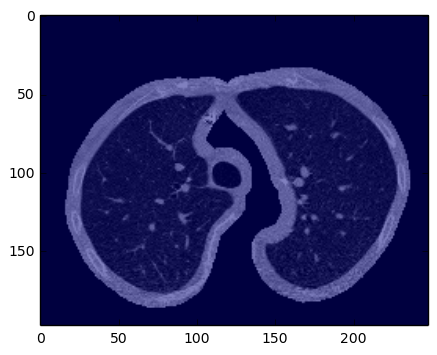

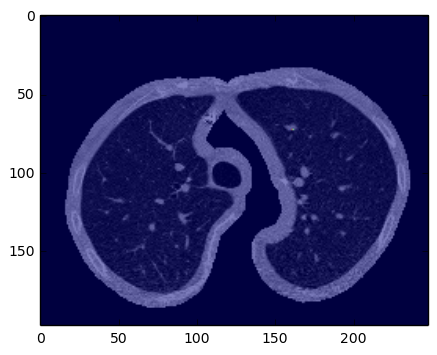

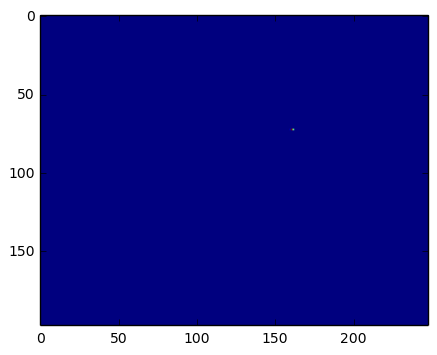

In [23]:
plt.figure()
plot_image_and_mask(t_image, t_nodule_mask)
plt.figure()
plot_image_and_mask(t_image, p_nodule_mask)
plt.figure()
plt.imshow(p_nodule_mask, cmap='jet')